# Mask R-CNN - Train on Concrete Dataset

In [8]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
from imgaug import augmenters as iaa
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Notebook Preferences

In [111]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Extend the Dataset class and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [10]:
class ConcreteDataset(utils.Dataset):
    """
    The dataset consists of concrete CT images.
    """

    def load_concrete(self, dataset_dir, subset, raw=False):
        """Load a subset of the concrete dataset.
        dataset_dir: Root directory of the dataset
        subset: train, val, or test
        """
        # Add classes
        self.raw = raw
        self.add_class("concrete", 1, "Background")
        self.add_class("concrete", 2, "Aggregate")
        self.add_class("concrete", 3, "Matrix")
        self.add_class("concrete", 4, "Pore")
        
        assert subset in ["train", "val", "test"]
        if self.raw:
            dataset_dir = os.path.join(dataset_dir, 'raw_image_100')
        else:
            dataset_dir = os.path.join(dataset_dir, 'raw_crop_image_100')

        image_ids = next(os.walk(dataset_dir))[2]

        for img in image_ids:
            if img.endswith(".tif") and \
            ((subset == "train" and int(img[:4]) <= 80) or \
            (subset == "val" and int(img[:4]) > 80)):
                self.add_image("concrete", image_id=img[:-4], path=os.path.join(dataset_dir, img))

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "concrete":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)
            

    def load_mask(self, image_id):
        """Generate instance masks for concrete of the given image ID.
        """
        info = self.image_info[image_id]
        path = info['path']
        if self.raw:
            mask_path = os.path.join(os.path.dirname(os.path.dirname(info['path'])), 'label_grey_100')
        else:
            mask_path = os.path.join(os.path.dirname(os.path.dirname(info['path'])), 'trainval')

        mask_dirs = ['A_phase', 'B_phase', 'C_phase', 'M_phase']
        image_name = os.path.split(path)[-1][:-4]
        
        # Read mask files from .tif image
        mask = []
        for i in range(len(mask_dirs)):
            image = os.path.join(mask_path, mask_dirs[i], image_name+"_mask.tif")
            m = skimage.io.imread(image).astype(np.bool)
            mask.append(m)
            
        mask = np.stack(mask, axis=-1)
        class_ids = np.array([1, 2, 3, 4], dtype=np.int32)
        return mask, class_ids

In [11]:
##############################
# Structure of the dataset:
# -dataset_dir
#     -train
#       -X
#        0001.tif
#        0002.tif ...
#       -y
#         -A_phase
#         -B_phase
#         -C_phase
#         -M_phase
#    -val
#       -X
#       -y
#         -A_phase
#         -B_phase
#         -C_phase
#         -M_phase
#   -test
#       -X
###############################
# Ignore the above structure 
# Code modified to accommodate current dataset structure
##############################
# Current Structure of the dataset:
# -dataset
#     -dataset_1
#       -raw_crop_image_100
#        0001.tif
#        0002.tif ...
#       -trainval
#         -A_phase
#           0001_mask.tif
#           0002_mask.tif ...
#         -B_phase
#         -C_phase
#         -M_phase
##############################

# Set path to the dataset
# dataset_dir = os.path.join(ROOT_DIR, "dataset/")
dataset_dir = "../data/dataset_1"

# Training dataset
dataset_train = ConcreteDataset()
dataset_train.load_concrete(dataset_dir, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = ConcreteDataset()
dataset_val.load_concrete(dataset_dir, "val")
dataset_val.prepare()

# Non-cropped dataset
dataset_val_all = ConcreteDataset()
dataset_val_all.load_concrete(dataset_dir, "val", raw=True)
dataset_val_all.prepare()

In [ ]:
# Image augmentation
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])
# import imgaug
# augmentation = imgaug.augmenters.Fliplr(0.5)

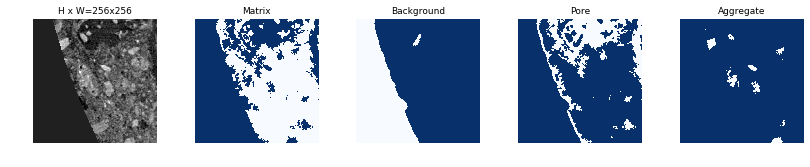

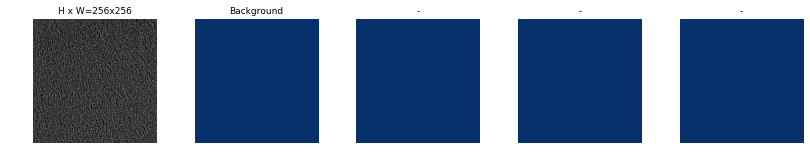

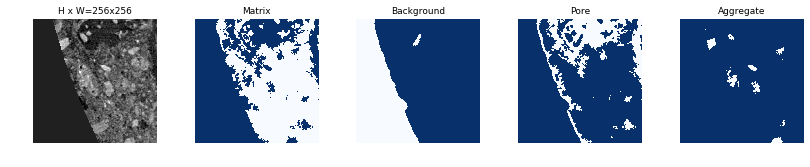

In [126]:
# # Load and display random samples
image_ids = np.random.choice(dataset_val_all.image_ids, 3)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Configurations

In [28]:
class ConcreteConfig(Config):
    """Configuration for training on the concrete dataset.
    Derives from the base Config class and overrides values specific
    to our own dataset.
    """
    # Give the configuration a recognizable name
    NAME = "concrete"

    # Train on 1 GPU and 4 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 4 (GPUs * IMAGES_PER_GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 classes

    # Set the limits of the small side and the large side,
    # which determines the image shape. 
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 64

    # Set number of steps per epoch
    STEPS_PER_EPOCH = 1000
    
    DETECTION_MIN_CONFIDENCE = 0.5
#     MAX_GT_INSTANCES = 200
#     DETECTION_MAX_INSTANCES = 400
    LEARNING_RATE = 0.0001

config = ConcreteConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

## Create Model

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [240]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 180


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. Simply pass `layers="all` to train all layers.

In [64]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
print("Training network heads")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40,
            augmentation=augmentation,
            layers='heads')

print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=120,
            layers='4+',
            augmentation=augmentation)

print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=140,
            layers='all',
            augmentation=augmentation)

print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=160,
            layers='all',
            augmentation=augmentation)

print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 100,
            epochs=180,
            layers='all',
            augmentation=augmentation)

Training network heads

Starting at epoch 163. LR=0.0001

Checkpoint Path: /data3/floraxue/cs282a/Mask_RCNN_concrete/logs/concrete20190502T0656/mask_rcnn_concrete_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
m

/data3/floraxue/cs282a/assn4env/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/data3/floraxue/cs282a/assn4env/lib/python3.5/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Fine tune Resnet stage 4 and up

Starting at epoch 163. LR=0.0001

Checkpoint Path: /data3/floraxue/cs282a/Mask_RCNN_concrete/logs/concrete20190502T0656/mask_rcnn_concrete_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b     

Fine tune all layers

Starting at epoch 163. LR=1e-05

Checkpoint Path: /data3/floraxue/cs282a/Mask_RCNN_concrete/logs/concrete20190502T0656/mask_rcnn_concrete_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchN

Fine tune all layers

Starting at epoch 163. LR=1e-06

Checkpoint Path: /data3/floraxue/cs282a/Mask_RCNN_concrete/logs/concrete20190502T0656/mask_rcnn_concrete_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchN

Epoch 164/180
1000/1000 [==============================] - 536s 536ms/step - loss: 1.1761 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.8400 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.1484 - val_loss: 1.4350 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 1.1724 - val_mrcnn_class_loss: 0.0954 - val_mrcnn_bbox_loss: 0.0486 - val_mrcnn_mask_loss: 0.1114
Epoch 165/180
1000/1000 [==============================] - 494s 494ms/step - loss: 1.4084 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 1.1003 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1347 - val_loss: 0.9687 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 0.5424 - val_mrcnn_class_loss: 0.0892 - val_mrcnn_bbox_loss: 0.0589 - val_mrcnn_mask_loss: 0.2747
Epoch 166/180
1000/1000 [==============================] - 492s 492ms/step - loss: 1.4525 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 1.0514 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1753 - val_loss: 

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=60,
#             augmentation=augmentation,
#             layers="all")

In [65]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_3.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [53]:
class InferenceConfig(ConcreteConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

class LargeConfig(ConcreteConfig):
    IMAGE_MIN_DIM = 2560
    IMAGE_MAX_DIM = 2560

inference_config = InferenceConfig()
large_config = LargeConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /data3/floraxue/cs282a/Mask_RCNN_concrete/logs/concrete20190502T0656/mask_rcnn_concrete_0180.h5
Re-starting from epoch 180


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32


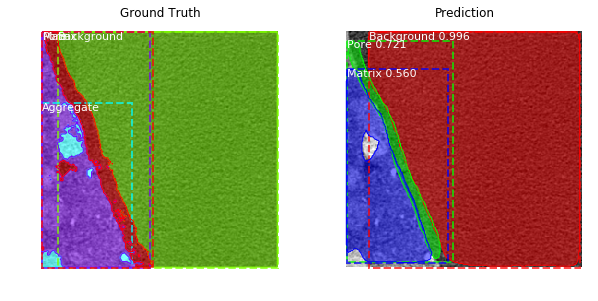

In [293]:
# Test on a random cropped image
crop_image_id = random.choice(dataset_val.image_ids)
crop_original_image, crop_image_meta, crop_gt_class_id, crop_gt_bbox, crop_gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           crop_image_id, use_mini_mask=False)


crop_f, (crop_ax1, crop_ax2) = plt.subplots(1, 2, sharey=True, figsize=[10, 5])
visualize.display_instances(crop_original_image, crop_gt_bbox, crop_gt_mask, crop_gt_class_id, 
                            dataset_train.class_names, ax=crop_ax1, title="Ground Truth")

r = model.detect([crop_original_image], verbose=1)[0]
visualize.display_instances(crop_original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=crop_ax2, title="Prediction")

In [294]:
crop_f.savefig('./predictions/cropped_prediction.png', dpi=fig.dpi)

In [295]:
# Test on a random full image
# image_id = random.choice(dataset_val_all.image_ids)
image_id = 2
original_image_large, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val_all, large_config, 
                           image_id, use_mini_mask=False)

In [296]:
info = dataset_val_all.image_info[image_id]
real_id = info['id'][:4] # get real id i.e. '0085'
print(real_id)

# get all sub original images i.e. '0085_row_00_col_00_crop.tif'
original_images = []
for i in range(37):
    for j in range(37):
        name = "{}_row_{}_col_{}_crop.tif".format(real_id, i, j)
        img = skimage.io.imread('../data/dataset_1/raw_crop_image_100/'+name)
        if img.ndim != 3:
            img = skimage.color.gray2rgb(img)
        original_images.append(img)

0098


In [297]:
results = []
for original_image in original_images:
    result = model.detect([original_image], verbose=1)
    results.append(result)

Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:   58.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -65.70000  max:  -45.90000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:   58.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -65.70000  max:  -45.90000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:   58.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -65.70000  max:  -45.90000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  113.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    9.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  114.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   10.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  114.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   10.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  115.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   11.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  120.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   16.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  121.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   17.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  111.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    7.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  110.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    6.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  108.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -115.70000  max:    4.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  122.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   18.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  122.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   18.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  122.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   18.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:   58.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -65.70000  max:  -45.90000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:   58.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -65.70000  max:  -45.90000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   24.00000  max:  102.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -99.70000  max:   -1.90000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  119.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   15.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  119.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   15.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  120.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   16.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  124.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   20.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  124.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   20.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  134.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   30.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  124.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   20.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  124.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   20.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  124.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   20.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  227.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  123.10000

image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  247.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  143.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  119.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   15.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  113.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    9.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  134.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   30.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -61.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  114.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -121.70000  max:   10.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  120.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   16.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  121.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   17.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  153.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -120.70000  max:   49.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  153.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:   49.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  133.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   29.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -55.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -63.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  113.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    9.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  113.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    9.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  127.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   23.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  249.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -118.70000  max:  145.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  236.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -110.70000  max:  132.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -91.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  127.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   23.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  114.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   10.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  110.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    6.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -65.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  115.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   11.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  124.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   20.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -100.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -83.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -101.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  119.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   15.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  115.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   11.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  126.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   22.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -103.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -121.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -102.70000  max:  151.10000

molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   10.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  109.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    5.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  109.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    5.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors   

Processing 1 images
image                    shape: (256, 256, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -94.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  135.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   31.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  141.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -120.70000  max:   37.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  253.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  149.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -117.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -107.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  115.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   11.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  115.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   11.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  115.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   11.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -105.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  120.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   16.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  112.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    8.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  120.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   16.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  148.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   44.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  224.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  120.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  249.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  145.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  131.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   27.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  129.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   25.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  121.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   17.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -109.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  110.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:    6.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  118.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -114.70000  max:   14.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  118.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   14.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  251.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  147.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  251.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -117.70000  max:  147.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  251.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -117.70000  max:  147.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  119.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   15.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  119.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   15.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  119.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   15.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  121.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   17.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  121.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   17.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  116.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   12.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000

image                    shape: (256, 256, 3)         min:    0.00000  max:  122.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   18.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  122.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   18.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  122.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -118.70000  max:   18.10000  float64
image_meta

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  112.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:    8.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  112.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:    8.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  119.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:   15.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  113.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    9.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  112.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    8.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  112.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    8.10000

anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  113.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    9.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  111.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    7.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  111.000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  108.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    4.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  104.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    0.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:   58.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -65.70000  max:  -45.90000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  120.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   16.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  120.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   16.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  120.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   16.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:   58.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -65.70000  max:  -45.90000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:   58.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -65.70000  max:  -45.90000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  108.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -115.70000  max:    4.10000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  110.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    6.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  110.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:    6.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  110.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:    6.10000

In [298]:
print(len(results))

1369


In [ ]:
masks = np.zeros((2560, 2560, 4))

# takes a while to rum
for index in range(len(results)):
    if index % 100 == 0:
        print(index)
    row, col = index // 37, index % 37
    m = results[index][0]['masks']
    # all class id in this masks
    classes = results[index][0]['class_ids']
    for c in range(len(classes)):
        for x in range(256):
            for y in range(256):
                i, j = row * 64 + x, col * 64 + y
                if m[x][y][c]:
                    masks[i][j][classes[c] - 1] += 1

0
100
200


In [ ]:
fig_gray, ax_gray = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12,6))

ax_gray[0].imshow(masks[:,:,0].astype(int), cmap='gray')
ax_gray[0].set_title('Background')
ax_gray[1].imshow(masks[:,:,1].astype(int), cmap='gray')
ax_gray[1].set_title('Aggregate')
ax_gray[2].imshow(masks[:,:,2].astype(int), cmap='gray')
ax_gray[2].set_title('Matrix')
ax_gray[3].imshow(masks[:,:,3].astype(int), cmap='gray')
ax_gray[3].set_title('Pore')
visualize.display_instances(original_image_large, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, ax=ax_gray[4], title="Ground Truth")

In [ ]:
fig_gray.savefig('./predictions/{}_prediction_grey.png'.format(real_id), dpi=fig.dpi)

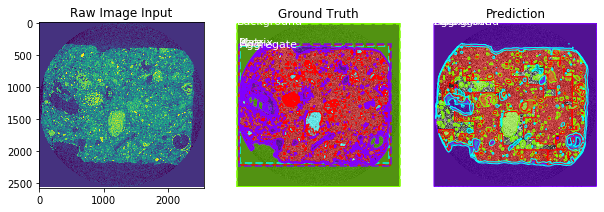

In [251]:
rois = np.array([[0, 0, 2560, 2560], [0, 0, 2560, 2560], [0, 0, 2560, 2560], [0, 0, 2560, 2560]])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=[10, 5])

inp = plt.imread('../data/dataset_1/raw_image_100/{}.tif'.format(real_id))
ax1.imshow(inp)
ax1.set_title('Raw Image Input')

visualize.display_instances(original_image_large, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, ax=ax2, title="Ground Truth")

visualize.display_instances(original_image_large, rois, masks.astype(bool), gt_class_id, 
                            dataset_val.class_names, ax=ax3, show_bbox=False, title="Prediction")

In [252]:
f.savefig('./predictions/{}_prediction.png'.format(real_id), dpi=fig.dpi)

In [ ]:
# results = model.detect([original_image], verbose=1)

# r = results[0]
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [45]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 10)
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.5212381320029119


In [ ]:
# first time: 0.36
# second time: 0.52